<a href="https://colab.research.google.com/github/hernandezhdd/Dataton-2022/blob/main/Dataton-2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FIUBA Dataton 2022 ZS Churn Challenge

Busquet Lucas, Hernández Hugo, Iriarte Tomás

We needed to predict whether a certain employee would be terminated next quarter. We began by loading the dataset and cleaning the data. Changing the data types and fixing NaN values. After inspecting the dataset and choosing certain features, we ran a Random Forest Classifier. This did not have a good performance, due to heavily unbalanced classes (15 Existing to 1 Terminated).

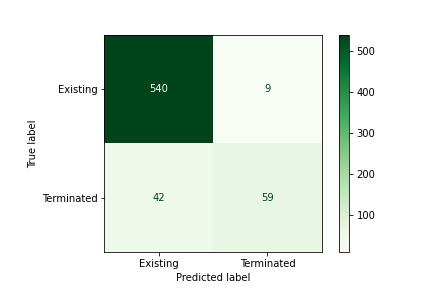



Finally we used SMOTE to oversample the minority class, taking care not to leak information into the training set, and re-ran the classifier, obtaining a much better performance.

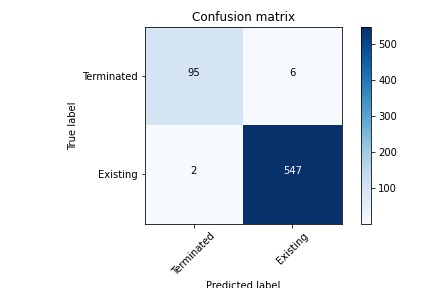

## Loading

In [1]:
import gdown

# !mkdir /content/Churn_ZS
output = "/content/churn.zip"
# https://drive.google.com/file/d/1YeGiTrAPTeq2oxAbtYqRHGkVf52-0AlG/view?usp=sharing
gdown.download(id='1YeGiTrAPTeq2oxAbtYqRHGkVf52-0AlG', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1YeGiTrAPTeq2oxAbtYqRHGkVf52-0AlG
To: /content/churn.zip
100%|██████████| 1.93M/1.93M [00:00<00:00, 106MB/s]


'/content/churn.zip'

In [2]:
!unzip -q -u /content/churn.zip -d /content #/Churn_ZS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_emp = pd.read_csv('/content/Churn_ZS/Q1_Q2_Emp.csv')
df_mgr = pd.read_csv('/content/Churn_ZS/Q1_Q2_Mgr.csv')
df_perf = pd.read_csv('/content/Churn_ZS/Q1_Q2_Perf.csv')
Q3_Submission = pd.read_csv('/content/Churn_ZS/Q3_Submission.csv')
pd.set_option("display.max_columns", None)

In [5]:
df_emp.head(1)#.shape, df_mgr.shape

,Unnamed: 0,Q1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Q2,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,Employee_ID,Type,Department,Area,Region_Lat,Region_Long,Legal_Entity,Product,Title,Gender,Marital_Status,prev_emplr_tenure,Home_Work_Match,Age,Quart_Tenure,Type,Department,Area,Region_Lat,Region_Long,Legal_Entity,Product,Title,Gender,Marital_Status,prev_emplr_tenure,Home_Work_Match,Age,Quart_Tenure


## Renaming columns

In [6]:
old_cols_emp = df_emp.loc[0].values
new_cols_emp = [old_cols_emp[0]]

for col in old_cols_emp[1:15]:
  new_cols_emp.append('Q1_'+col)
for col in old_cols_emp[15:]:
  new_cols_emp.append('Q2_'+col)

print(new_cols_emp)

['Employee_ID', 'Q1_Type', 'Q1_Department', 'Q1_Area', 'Q1_Region_Lat', 'Q1_Region_Long', 'Q1_Legal_Entity', 'Q1_Product', 'Q1_Title', 'Q1_Gender', 'Q1_Marital_Status', 'Q1_prev_emplr_tenure', 'Q1_Home_Work_Match', 'Q1_Age', 'Q1_Quart_Tenure', 'Q2_Type', 'Q2_Department', 'Q2_Area', 'Q2_Region_Lat', 'Q2_Region_Long', 'Q2_Legal_Entity', 'Q2_Product', 'Q2_Title', 'Q2_Gender', 'Q2_Marital_Status', 'Q2_prev_emplr_tenure', 'Q2_Home_Work_Match', 'Q2_Age', 'Q2_Quart_Tenure']


In [7]:
old_cols_mgr = df_mgr.loc[0].values
new_cols_mgr = [old_cols_mgr[0]]

for col in old_cols_mgr[1:7]:
  new_cols_mgr.append('Q1_'+col)
for col in old_cols_mgr[7:]:
  new_cols_mgr.append('Q2_'+col)

print(new_cols_mgr)

['Employee_ID', 'Q1_Mgr_Geo_Match', 'Q1_Mgr_Avg_SY', 'Q1_Mgr_Avg_SY_T', 'Q1_Mgr_Avg_SY_E', 'Q1_Mgr_Termination_Rate', 'Q1_Mgr_Title', 'Q2_Mgr_Geo_Match', 'Q2_Mgr_Avg_SY', 'Q2_Mgr_Avg_SY_T', 'Q2_Mgr_Avg_SY_E', 'Q2_Mgr_Termination_Rate', 'Q2_Mgr_Title']


In [8]:
old_cols_perf = df_perf.loc[0].values
new_cols_perf = [old_cols_perf[0]]

for col in old_cols_perf[1:13]:
  new_cols_perf.append('Q1_'+col)
for col in old_cols_perf[13:]:
  new_cols_perf.append('Q2_'+col)

print(new_cols_perf)

['Employee_ID', 'Q1_incentiveQ_1', 'Q1_incentiveQ1_Q2', 'Q1_incentiveQ2_Q3', 'Q1_incentiveQ1_Q3', 'Q1_salesQ_1', 'Q1_salesQ1_Q2', 'Q1_salesQ2_Q3', 'Q1_salesQ1_Q3', 'Q1_targetQ_1', 'Q1_targetQ1_Q2', 'Q1_targetQ2_Q3', 'Q1_targetQ1_Q3', 'Q2_incentiveQ_1', 'Q2_incentiveQ1_Q2', 'Q2_incentiveQ2_Q3', 'Q2_incentiveQ1_Q3', 'Q2_salesQ_1', 'Q2_salesQ1_Q2', 'Q2_salesQ2_Q3', 'Q2_salesQ1_Q3', 'Q2_targetQ_1', 'Q2_targetQ1_Q2', 'Q2_targetQ2_Q3', 'Q2_targetQ1_Q3']


In [9]:
df_emp.columns = new_cols_emp
df_emp = df_emp.drop(0)
df_mgr.columns = new_cols_mgr
df_mgr = df_mgr.drop(0)
df_perf.columns = new_cols_perf
df_perf = df_perf.drop(0)

In [10]:
df_final = pd.merge(df_emp, df_mgr, on ='Employee_ID', how ="inner")

In [11]:
df_final = pd.merge(df_final, df_perf, on ='Employee_ID', how ="inner")

In [12]:
df_final = df_final.applymap(pd.to_numeric, errors='ignore')
# df_final.info(verbose=True)

In [13]:
df_final.head(2)

,Employee_ID,Q1_Type,Q1_Department,Q1_Area,Q1_Region_Lat,Q1_Region_Long,Q1_Legal_Entity,Q1_Product,Q1_Title,Q1_Gender,Q1_Marital_Status,Q1_prev_emplr_tenure,Q1_Home_Work_Match,Q1_Age,Q1_Quart_Tenure,Q2_Type,Q2_Department,Q2_Area,Q2_Region_Lat,Q2_Region_Long,Q2_Legal_Entity,Q2_Product,Q2_Title,Q2_Gender,Q2_Marital_Status,Q2_prev_emplr_tenure,Q2_Home_Work_Match,Q2_Age,Q2_Quart_Tenure,Q1_Mgr_Geo_Match,Q1_Mgr_Avg_SY,Q1_Mgr_Avg_SY_T,Q1_Mgr_Avg_SY_E,Q1_Mgr_Termination_Rate,Q1_Mgr_Title,Q2_Mgr_Geo_Match,Q2_Mgr_Avg_SY,Q2_Mgr_Avg_SY_T,Q2_Mgr_Avg_SY_E,Q2_Mgr_Termination_Rate,Q2_Mgr_Title,Q1_incentiveQ_1,Q1_incentiveQ1_Q2,Q1_incentiveQ2_Q3,Q1_incentiveQ1_Q3,Q1_salesQ_1,Q1_salesQ1_Q2,Q1_salesQ2_Q3,Q1_salesQ1_Q3,Q1_targetQ_1,Q1_targetQ1_Q2,Q1_targetQ2_Q3,Q1_targetQ1_Q3,Q2_incentiveQ_1,Q2_incentiveQ1_Q2,Q2_incentiveQ2_Q3,Q2_incentiveQ1_Q3,Q2_salesQ_1,Q2_salesQ1_Q2,Q2_salesQ2_Q3,Q2_salesQ1_Q3,Q2_targetQ_1,Q2_targetQ1_Q2,Q2_targetQ2_Q3,Q2_targetQ1_Q3
0,193852,Terminated,Dept-2,Area-12,38.03706,114.4687,Entity-1,Product-2,Grade-7,M,Single,1.86,NaN,24.511978,2.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.771507,0.000000,1.771507,0.0,Grade-M5,1,2.020274,0.649315,2.363014,0.200000,Grade-M5,6810.0,0.486465,14001.0,6811.0,223074.0,1.180613,188948.5,223075.0,204000.0,1.439966,141670.68,204001.0,18895.8333,2.774458,0.486465,1.349677,257958.0,1.156378,1.180613,1.365234,215475.0,1.056250,1.439966,1.520964
1,193857,Existing,Dept-3,Other,32.06171,118.7632,Entity-4,Product-1,Grade-8,F,Marr.,2.59,NaN,29.941136,2.855556,Existing,Dept-3,Other,32.06171,118.7632,Entity-4,Product-1,Grade-8,F,Marr.,2.59,0.0,30.193018,3.877778,1.0,2.062466,3.247945,1.272146,0.4,Grade-M5,1,1.868950,3.247945,1.179452,0.333333,Grade-M5,16895.0,1.126325,15001.0,16896.0,1276800.0,1.251668,1020079.6,1276801.0,1199280.0,0.788659,1520657.80,1199281.0,47686.4000,2.822408,1.126325,3.178948,1360400.0,1.065476,1.251668,1.333622,1308720.0,1.091255,0.788659,0.860628


In [14]:
df_final.describe()

,Employee_ID,Q1_Region_Lat,Q1_Region_Long,Q1_prev_emplr_tenure,Q1_Home_Work_Match,Q1_Age,Q1_Quart_Tenure,Q2_Region_Lat,Q2_Region_Long,Q2_prev_emplr_tenure,Q2_Home_Work_Match,Q2_Age,Q2_Quart_Tenure,Q1_Mgr_Geo_Match,Q1_Mgr_Avg_SY,Q1_Mgr_Avg_SY_T,Q1_Mgr_Avg_SY_E,Q1_Mgr_Termination_Rate,Q2_Mgr_Geo_Match,Q2_Mgr_Avg_SY,Q2_Mgr_Avg_SY_T,Q2_Mgr_Avg_SY_E,Q2_Mgr_Termination_Rate,Q1_incentiveQ_1,Q1_incentiveQ1_Q2,Q1_incentiveQ2_Q3,Q1_incentiveQ1_Q3,Q1_salesQ_1,Q1_salesQ1_Q2,Q1_salesQ2_Q3,Q1_salesQ1_Q3,Q1_targetQ_1,Q1_targetQ1_Q2,Q1_targetQ2_Q3,Q1_targetQ1_Q3,Q2_incentiveQ_1,Q2_incentiveQ1_Q2,Q2_incentiveQ2_Q3,Q2_incentiveQ1_Q3,Q2_salesQ_1,Q2_salesQ1_Q2,Q2_salesQ2_Q3,Q2_salesQ1_Q3,Q2_targetQ_1,Q2_targetQ1_Q2,Q2_targetQ2_Q3,Q2_targetQ1_Q3
count,3521.000000,3233.000000,3233.000000,3068.000000,1307.000000,3222.000000,3233.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3089.000000,3233.000000,3233.000000,3233.000000,3233.000000,3521.000000,3521.000000,3521.000000,3521.000000,3521.000000,3233.000000,3233.000000,3233.000000,3233.000000,3.233000e+03,3.233000e+03,3.233000e+03,3.233000e+03,3.233000e+03,3.233000e+03,3.233000e+03,3.233000e+03,3521.000000,3521.000000,3521.000000,3521.000000,3.521000e+03,3.521000e+03,3.521000e+03,3.521000e+03,3.521000e+03,3.521000e+03,3.521000e+03,3.521000e+03
mean,580145.521443,33.264828,114.848918,1.222291,0.670237,27.997957,7.540881,33.224422,115.086748,1.176365,0.292113,27.920753,7.629247,0.921010,1.811258,0.692780,1.767276,0.080604,0.881568,1.772706,0.971596,1.680208,0.121785,12990.299922,3634.215708,2603.003305,2442.824563,3.285892e+05,2.390212e+04,1.712286e+04,4.705174e+04,3.347151e+05,2.698765e+04,2.374362e+04,5.187351e+04,16858.979326,1682.527409,3340.924184,4791.664812,3.358733e+05,1.970230e+04,2.247580e+04,5.069597e+04,3.560441e+05,2.636262e+04,2.620829e+04,6.050563e+04
std,277327.796729,6.207583,7.315841,1.427273,0.470307,3.629490,7.126214,6.172458,7.126981,1.378795,0.454808,3.868933,7.282147,0.269767,1.021325,1.196578,1.054542,0.162093,0.323165,0.955094,1.357486,1.000004,0.203367,12752.124740,8994.602693,7157.708817,6472.173245,3.164414e+05,1.123656e+05,1.078062e+05,1.614082e+05,2.993998e+05,1.172029e+05,1.305860e+05,1.671704e+05,16969.207633,5402.573601,8676.278775,11234.185908,3.303857e+05,8.747673e+04,1.075823e+05,1.548032e+05,3.166796e+05,1.067878e+05,1.189678e+05,1.732646e+05
min,23029.000000,20.017380,87.627700,0.000000,0.000000,20.492813,-0.011111,20.017380,87.627700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000012,0.000012,-2.891100e+04,-4.414286e+01,-4.536012e+05,-1.831455e+01,0.000000e+00,4.140000e-07,4.060000e-06,2.590000e-07,0.000000,0.000014,0.000011,0.000012,-5.184000e+04,-4.091900e+04,-4.959560e+03,-4.091900e+04,0.000000e+00,3.520000e-07,1.698299e-03,2.590000e-07
25%,206294.000000,30.267440,113.266500,0.080000,0.000000,25.391513,2.511111,30.267440,113.266500,0.000000,0.000000,25.284052,2.255556,1.000000,1.172994,0.000000,1.063470,0.000000,1.000000,1.155616,0.000000,1.005479,0.000000,0.000000,0.514162,0.733931,0.664686,1.121000e+05,7.616186e-01,9.562777e-01,7.893659e-01,1.522170e+05,7.058863e-01,1.000000e+00,7.821503e-01,0.000000,1.000000,0.549363,0.816589,1.012400e+05,9.478690e-01,8.813761e-01,7.936568e-01,1.585740e+05,1.000000e+00,8.382997e-01,7.557100e-01
50%,801105.000000,32.061710,116.407400,0.830000,1.000000,27.405886,5.355556,32.061710,116.407400,0.790000,0.000000,27.353867,5.344444,1.000000,1.746119,0.000000,1.718721,0.000000,1.000000,1.718721,0.000000,1.642740,0.000000,11985.620000,1.000000,1.000000,1.000000,2.766400e+05,1.000000e+00,1.000000e+00,1.012303e+00,2.915670e+05,1.000000e+00,1.034337e+00,1.000000e+00,15400.000000,1.345461,1.000000,1.000000,2.822830e+05,1.061949e+00,1.000000e+00,1.087327e+00,3.085250e+05,1.079917e+00,1.000000e+00,1.012961e+00
75%,804009.000000,39.084160,119.295100,1.810000,1.000000,30.110883,11.177778,38.471320,119.295100,1.

## Cleaning

In [15]:
# df_final.isna().sum()[~df_final.isna().sum().eq(0)]

In [16]:
mask = (df_final.Q1_salesQ_1<20)

df_final.loc[mask,'Q1_salesQ_1'] = np.nan# = df_final.loc[mask]
df_final.loc[mask,'Q1_salesQ_1']

mask = (df_final.Q2_salesQ_1<20)

df_final.loc[mask,'Q2_salesQ_1'] = np.nan# = df_final.loc[mask]
df_final.loc[mask,'Q2_salesQ_1']

mask = df_final.Q1_salesQ_1 == df_final.Q2_salesQ_1

df_final.loc[mask,'Q2_salesQ_1'] = np.nan# = df_final.loc[mask]
df_final.loc[mask,'Q2_salesQ_1']

df_final.head(1)

,Employee_ID,Q1_Type,Q1_Department,Q1_Area,Q1_Region_Lat,Q1_Region_Long,Q1_Legal_Entity,Q1_Product,Q1_Title,Q1_Gender,Q1_Marital_Status,Q1_prev_emplr_tenure,Q1_Home_Work_Match,Q1_Age,Q1_Quart_Tenure,Q2_Type,Q2_Department,Q2_Area,Q2_Region_Lat,Q2_Region_Long,Q2_Legal_Entity,Q2_Product,Q2_Title,Q2_Gender,Q2_Marital_Status,Q2_prev_emplr_tenure,Q2_Home_Work_Match,Q2_Age,Q2_Quart_Tenure,Q1_Mgr_Geo_Match,Q1_Mgr_Avg_SY,Q1_Mgr_Avg_SY_T,Q1_Mgr_Avg_SY_E,Q1_Mgr_Termination_Rate,Q1_Mgr_Title,Q2_Mgr_Geo_Match,Q2_Mgr_Avg_SY,Q2_Mgr_Avg_SY_T,Q2_Mgr_Avg_SY_E,Q2_Mgr_Termination_Rate,Q2_Mgr_Title,Q1_incentiveQ_1,Q1_incentiveQ1_Q2,Q1_incentiveQ2_Q3,Q1_incentiveQ1_Q3,Q1_salesQ_1,Q1_salesQ1_Q2,Q1_salesQ2_Q3,Q1_salesQ1_Q3,Q1_targetQ_1,Q1_targetQ1_Q2,Q1_targetQ2_Q3,Q1_targetQ1_Q3,Q2_incentiveQ_1,Q2_incentiveQ1_Q2,Q2_incentiveQ2_Q3,Q2_incentiveQ1_Q3,Q2_salesQ_1,Q2_salesQ1_Q2,Q2_salesQ2_Q3,Q2_salesQ1_Q3,Q2_targetQ_1,Q2_targetQ1_Q2,Q2_targetQ2_Q3,Q2_targetQ1_Q3
0,193852,Terminated,Dept-2,Area-12,38.03706,114.4687,Entity-1,Product-2,Grade-7,M,Single,1.86,NaN,24.511978,2.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.771507,0.0,1.771507,0.0,Grade-M5,1,2.020274,0.649315,2.363014,0.2,Grade-M5,6810.0,0.486465,14001.0,6811.0,223074.0,1.180613,188948.5,223075.0,204000.0,1.439966,141670.68,204001.0,18895.8333,2.774458,0.486465,1.349677,257958.0,1.156378,1.180613,1.365234,215475.0,1.05625,1.439966,1.520964


In [17]:
df_final.head(1)

,Employee_ID,Q1_Type,Q1_Department,Q1_Area,Q1_Region_Lat,Q1_Region_Long,Q1_Legal_Entity,Q1_Product,Q1_Title,Q1_Gender,Q1_Marital_Status,Q1_prev_emplr_tenure,Q1_Home_Work_Match,Q1_Age,Q1_Quart_Tenure,Q2_Type,Q2_Department,Q2_Area,Q2_Region_Lat,Q2_Region_Long,Q2_Legal_Entity,Q2_Product,Q2_Title,Q2_Gender,Q2_Marital_Status,Q2_prev_emplr_tenure,Q2_Home_Work_Match,Q2_Age,Q2_Quart_Tenure,Q1_Mgr_Geo_Match,Q1_Mgr_Avg_SY,Q1_Mgr_Avg_SY_T,Q1_Mgr_Avg_SY_E,Q1_Mgr_Termination_Rate,Q1_Mgr_Title,Q2_Mgr_Geo_Match,Q2_Mgr_Avg_SY,Q2_Mgr_Avg_SY_T,Q2_Mgr_Avg_SY_E,Q2_Mgr_Termination_Rate,Q2_Mgr_Title,Q1_incentiveQ_1,Q1_incentiveQ1_Q2,Q1_incentiveQ2_Q3,Q1_incentiveQ1_Q3,Q1_salesQ_1,Q1_salesQ1_Q2,Q1_salesQ2_Q3,Q1_salesQ1_Q3,Q1_targetQ_1,Q1_targetQ1_Q2,Q1_targetQ2_Q3,Q1_targetQ1_Q3,Q2_incentiveQ_1,Q2_incentiveQ1_Q2,Q2_incentiveQ2_Q3,Q2_incentiveQ1_Q3,Q2_salesQ_1,Q2_salesQ1_Q2,Q2_salesQ2_Q3,Q2_salesQ1_Q3,Q2_targetQ_1,Q2_targetQ1_Q2,Q2_targetQ2_Q3,Q2_targetQ1_Q3
0,193852,Terminated,Dept-2,Area-12,38.03706,114.4687,Entity-1,Product-2,Grade-7,M,Single,1.86,NaN,24.511978,2.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.771507,0.0,1.771507,0.0,Grade-M5,1,2.020274,0.649315,2.363014,0.2,Grade-M5,6810.0,0.486465,14001.0,6811.0,223074.0,1.180613,188948.5,223075.0,204000.0,1.439966,141670.68,204001.0,18895.8333,2.774458,0.486465,1.349677,257958.0,1.156378,1.180613,1.365234,215475.0,1.05625,1.439966,1.520964


In [18]:
# mask = df_final.Q1_salesQ_1 != df_final.Q2_salesQ_1

df_final_Q1 = df_final[['Employee_ID', 'Q1_Type', 'Q1_Product',
                       'Q1_Legal_Entity', 'Q1_Home_Work_Match',
                       'Q1_Age', 'Q1_Quart_Tenure', 'Q1_Mgr_Geo_Match', 'Q1_Mgr_Termination_Rate',
                       'Q1_salesQ_1']]#.loc[mask]

df_final_Q1.columns = ['Employee_ID', 'Type', 'Product', 'Legal_Entity',
              'Home_Work_Match', 'Age', 'Quart_Tenure', 'Mgr_Geo_Match',
              'Mgr_Termination_Rate', 'salesQ_1']

df_final_Q1['Q'] = 'Q1'

df_final_Q1.tail(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Employee_ID,Type,Product,Legal_Entity,Home_Work_Match,Age,Quart_Tenure,Mgr_Geo_Match,Mgr_Termination_Rate,salesQ_1,Q
3520,211253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q1


In [19]:
[f'Q2{i[2:]}' for i in ['Q1_Type', 'Q1_Product',
                       'Q1_Legal_Entity', 'Q1_Home_Work_Match',
                       'Q1_Age', 'Q1_Mgr_Geo_Match', 'Q1_Mgr_Termination_Rate',
                       'Q1_salesQ_1']]

['Q2_Type',
 'Q2_Product',
 'Q2_Legal_Entity',
 'Q2_Home_Work_Match',
 'Q2_Age',
 'Q2_Mgr_Geo_Match',
 'Q2_Mgr_Termination_Rate',
 'Q2_salesQ_1']

In [20]:
[f'{i[3:]}' for i in ['Q1_Type', 'Q1_Product',
                       'Q1_Legal_Entity', 'Q1_Home_Work_Match',
                       'Q1_Age', 'Q1_Mgr_Geo_Match', 'Q1_Mgr_Termination_Rate',
                       'Q1_salesQ_1']]

['Type',
 'Product',
 'Legal_Entity',
 'Home_Work_Match',
 'Age',
 'Mgr_Geo_Match',
 'Mgr_Termination_Rate',
 'salesQ_1']

In [21]:
# mask = df_final.Q1_salesQ_1 != df_final.Q2_salesQ_1

df_final_Q2 = df_final[['Employee_ID', 'Q2_Type',
            'Q2_Product', 'Q2_Legal_Entity', 'Q2_Home_Work_Match',
            'Q2_Age','Q1_Quart_Tenure', 'Q2_Mgr_Geo_Match', 'Q2_Mgr_Termination_Rate',
            'Q2_salesQ_1']]#.loc[mask]

df_final_Q2.columns = ['Employee_ID', 'Type', 'Product', 'Legal_Entity',
              'Home_Work_Match', 'Age', 'Quart_Tenure', 'Mgr_Geo_Match',
              'Mgr_Termination_Rate', 'salesQ_1']

df_final_Q2.loc[:,'Q'] = 'Q2'

df_final_Q2.tail(1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Employee_ID,Type,Product,Legal_Entity,Home_Work_Match,Age,Quart_Tenure,Mgr_Geo_Match,Mgr_Termination_Rate,salesQ_1,Q
3520,211253,Existing,Product-20,Entity-3,1.0,24.095825,NaN,1,0.0,NaN,Q2


In [22]:
df_final_2 = pd.concat([df_final_Q1, df_final_Q2], axis=0).reset_index()
df_final_2.tail(1)

,index,Employee_ID,Type,Product,Legal_Entity,Home_Work_Match,Age,Quart_Tenure,Mgr_Geo_Match,Mgr_Termination_Rate,salesQ_1,Q
7041,3520,211253,Existing,Product-20,Entity-3,1.0,24.095825,NaN,1.0,0.0,NaN,Q2


In [23]:
df_final_2.to_excel('df_final_orig.xlsx')

In [24]:
df_Q1 = df_final_Q1.copy()

## Constructing X and y

In [25]:
df_Q1 = df_Q1.drop(columns={'Q'})
df_Q1 = df_Q1.set_index('Employee_ID')


In [26]:
df_Q1.head()

,Type,Product,Legal_Entity,Home_Work_Match,Age,Quart_Tenure,Mgr_Geo_Match,Mgr_Termination_Rate,salesQ_1
Employee_ID,,,,,,,,,
193852,Terminated,Product-2,Entity-1,NaN,24.511978,2.633333,1.0,0.0,223074.00
193857,Existing,Product-1,Entity-4,NaN,29.941136,2.855556,1.0,0.4,1276800.00
194063,Existing,Product-21,Entity-4,1.0,28.501027,2.744444,1.0,0.0,112480.00
194065,Existing,Product-17,Entity-3,NaN,27.619439,2.677778,1.0,0.2,325066.41
194069,Existing,Product-17,Entity-3,NaN,28.013689,2.677778,1.0,0.0,161504.97


In [27]:
df_Q1.T.isna().any()#.head()

Employee_ID
193852     True
193857     True
194063    False
194065     True
194069     True
          ...  
209204     True
209440     True
211072     True
211076     True
211253     True
Length: 3521, dtype: bool

In [28]:
df_Q1 = df_Q1.drop(columns={'Home_Work_Match'})
df_Q1 = df_Q1.loc[~df_Q1.T.isna().any()]

In [29]:
df_Q1.isna().sum()

Type                    0
Product                 0
Legal_Entity            0
Age                     0
Quart_Tenure            0
Mgr_Geo_Match           0
Mgr_Termination_Rate    0
salesQ_1                0
dtype: int64

In [30]:
df_Q1.shape

(2598, 8)

In [31]:
pd.get_dummies(df_Q1.drop(columns={'Type'}), columns=['Product',	'Legal_Entity'])

,Age,Quart_Tenure,Mgr_Geo_Match,Mgr_Termination_Rate,salesQ_1,Product_Other,Product_Product-1,Product_Product-11,Product_Product-12,Product_Product-13,Product_Product-14,Product_Product-15,Product_Product-16,Product_Product-17,Product_Product-18,Product_Product-19,Product_Product-2,Product_Product-20,Product_Product-21,Product_Product-3,Product_Product-4,Product_Product-5,Product_Product-6,Product_Product-7,Product_Product-8,Product_Product-9,Legal_Entity_Entity-1,Legal_Entity_Entity-2,Legal_Entity_Entity-3,Legal_Entity_Entity-4
Employee_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
193852,24.511978,2.633333,1.0,0.0,223074.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
193857,29.941136,2.855556,1.0,0.4,1276800.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
194063,28.501027,2.744444,1.0,0.0,112480.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
194065,27.619439,2.677778,1.0,0.2,325066.41,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
194069,28.013689,2.677778,1.0,0.0,161504.97,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804145,27.945243,6.133333,1.0,0.0,265738.14,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
804149,22.600958,6.088889,1.0,0.0,1333980.43,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
804150,27.515400,6.088889,1.0,0.0,568899.64,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [32]:
y = pd.get_dummies(df_Q1['Type'], columns='Type')
y = y['Terminated'].to_numpy()

# df_Q1 = 
X = pd.get_dummies(df_Q1.drop(columns={'Type'}), columns=['Product',	'Legal_Entity'])


In [33]:
1/np.mean(y)

7.31830985915493

In [34]:
X.shape 

(2598, 30)

Unique predicted labels:  [0]
Test score:  0.8446153846153847


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


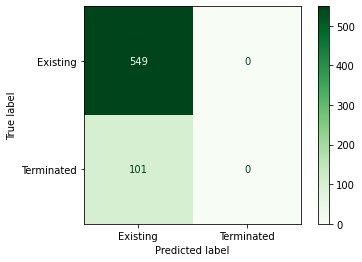

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import plot_confusion_matrix

# Separate input features and target

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

plot_confusion_matrix(dummy, X_test, y_test,
                            display_labels=['Existing', 'Terminated'], cmap='Greens')

## Random Forest Classifier

Mean ROC AUC: 0.867


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


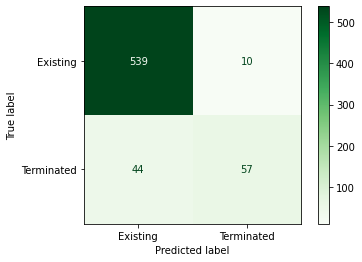

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix

# train model
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced')#.fit(X_train, y_train)
# {0: 1, 1:2}
# class_weight = {class_label: weight}
# class_weight = 'balanced'
# balanced

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rfc, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

rfc.fit(X_train, y_train)

plot_confusion_matrix(rfc, X_test, y_test,
                            display_labels=['Existing', 'Terminated'], cmap='Greens')
plt.savefig('badmatrix.jpg')
# predict on test set
# rfc_pred = rfc.predict(X_test)

# print(accuracy_score(y_test, rfc_pred))

# print(f1_score(y_test, rfc_pred))

# print(recall_score(y_test, rfc_pred))

In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier

rfc = BalancedRandomForestClassifier(n_estimators=100, class_weight='balanced_subsample')#.fit(X_train, y_train)
# {0: 1, 1:2}
# class_weight = {class_label: weight}
# class_weight = 'balanced'
# balanced

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rfc, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.905


## Random Forest Classifier with SMOTE

In [38]:
from imblearn.ensemble import EasyEnsembleClassifier

from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
# over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)

over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(X, y, test_size=0.2)

over_X_train, over_y_train = oversample.fit_resample(over_X_train, over_y_train)

SMOTE_SRF = RandomForestClassifier(n_estimators=100)#.fit(X_train, y_train)
# {0: 1, 1:2}
# class_weight = {class_label: weight}
# class_weight = 'balanced'
# balanced

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(SMOTE_SRF, over_X, over_y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.987


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x720 with 0 Axes>

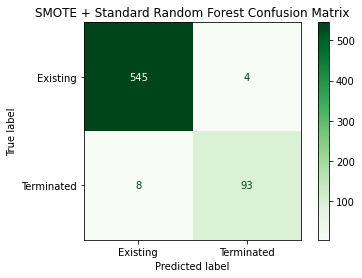

In [39]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(SMOTE_SRF, X_test, y_test,
                            display_labels=['Existing', 'Terminated'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

In [40]:
print(accuracy_score(y_test, y_pred))

print(f1_score(y_test, y_pred))

print(recall_score(y_test, y_pred))

0.9815384615384616
0.9393939393939394
0.9207920792079208


In [41]:
yhat = y_pred

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    confusion_matrix(y_test, yhat, labels=[1,0])

Confusion matrix, without normalization
[[ 93   8]
 [  4 545]]


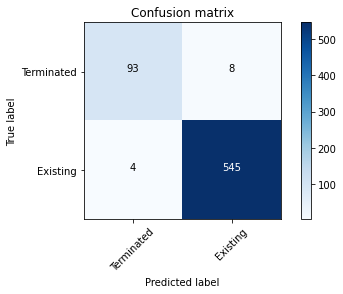

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(cnf_matrix,
                      classes=['Terminated','Existing'],
                      normalize= False,  title='Confusion matrix')
ax.set_facecolor('white') 
plt.savefig('matrix.jpg')
# plot_confusion_matrix(axis=ax)

In [43]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [44]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.026 seconds


In [45]:
X.head(1)

,Age,Quart_Tenure,Mgr_Geo_Match,Mgr_Termination_Rate,salesQ_1,Product_Other,Product_Product-1,Product_Product-11,Product_Product-12,Product_Product-13,Product_Product-14,Product_Product-15,Product_Product-16,Product_Product-17,Product_Product-18,Product_Product-19,Product_Product-2,Product_Product-20,Product_Product-21,Product_Product-3,Product_Product-4,Product_Product-5,Product_Product-6,Product_Product-7,Product_Product-8,Product_Product-9,Legal_Entity_Entity-1,Legal_Entity_Entity-2,Legal_Entity_Entity-3,Legal_Entity_Entity-4
Employee_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
193852,24.511978,2.633333,1.0,0.0,223074.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


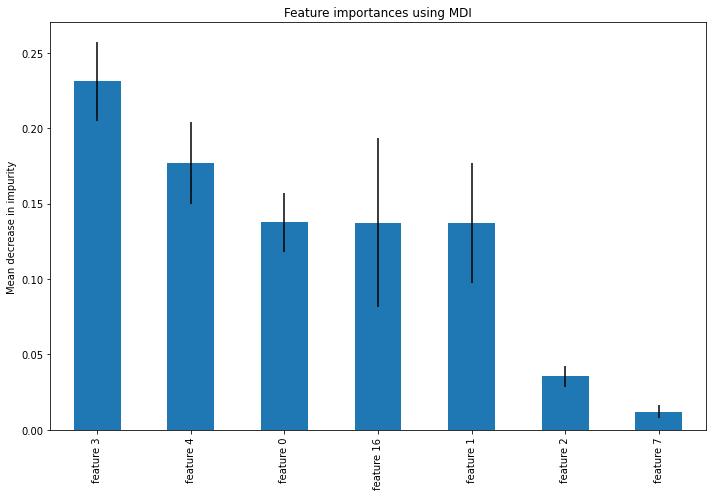

In [46]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances[0:7].plot.bar(yerr=std[0:7], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks()
fig.tight_layout()